In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pylab as plt
import zipfile
import os
import cv2
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import time
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report,confusion_matrix
from torch.utils.data import DataLoader, random_split
from sklearn.manifold import TSNE
import sklearn.metrics as metrics
import numpy as np


from google.colab import drive
drive.mount('/content/drive')

zip_file_path = 'drive/My Drive/Datasets'

with zipfile.ZipFile(zip_file_path + '/Dataset_1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Mounted at /content/drive


In [2]:
# Define path to your dataset folder
dataset_dir = '/content/Dataset_1'

# Create a dataset instance
dataset = datasets.ImageFolder(root=dataset_dir)

# Define the sizes of train, validation sets
train_size = int(0.7 * len(dataset))   # 70% of the dataset for training
val_size = int(0.1 * len(dataset))   # Remaining 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for testing


# Split the dataset into train, validation, and test sets
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),  # Resize images to match Inception input size
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transformations to train and test datasets
train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform
test_dataset.dataset.transform = valid_transform

# Define batch size for data loaders
batch_size = 32

# Create data loaders for train, validation, and test sets
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

10269
1467
2935


In [3]:
if len(dataset) != train_size + val_size + test_size:
    print("The sum of train and validation and test sizes does not equal the dataset size.")

In [6]:
# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = len(dataset.classes)
print(num_classes)
print(dataset.classes)

# Define the Inception model
model = models.inception_v3(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)


6
['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [7]:
# Define the Inception model
model = models.inception_v3(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Train the model
num_epochs = 15
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_data_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Testing phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in valid_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    valid_loss = running_loss / len(valid_data_loader)
    valid_acc = correct_test / total_test
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Acc: {valid_acc:.4f}")


Epoch [1/15], Train Loss: 0.6836, Train Acc: 0.7443, Validation Loss: 0.4053, Validation Acc: 0.8473
Epoch [2/15], Train Loss: 0.3480, Train Acc: 0.8745, Validation Loss: 0.3712, Validation Acc: 0.8616
Epoch [3/15], Train Loss: 0.2198, Train Acc: 0.9242, Validation Loss: 0.1757, Validation Acc: 0.9468
Epoch [4/15], Train Loss: 0.1867, Train Acc: 0.9333, Validation Loss: 0.1252, Validation Acc: 0.9591
Epoch [5/15], Train Loss: 0.1337, Train Acc: 0.9548, Validation Loss: 0.1583, Validation Acc: 0.9530
Epoch [6/15], Train Loss: 0.1245, Train Acc: 0.9582, Validation Loss: 0.1807, Validation Acc: 0.9414
Epoch [7/15], Train Loss: 0.1046, Train Acc: 0.9647, Validation Loss: 0.0786, Validation Acc: 0.9755
Epoch [8/15], Train Loss: 0.0884, Train Acc: 0.9716, Validation Loss: 0.0999, Validation Acc: 0.9775
Epoch [9/15], Train Loss: 0.0861, Train Acc: 0.9712, Validation Loss: 0.0638, Validation Acc: 0.9816
Epoch [10/15], Train Loss: 0.0781, Train Acc: 0.9754, Validation Loss: 0.0801, Validation A

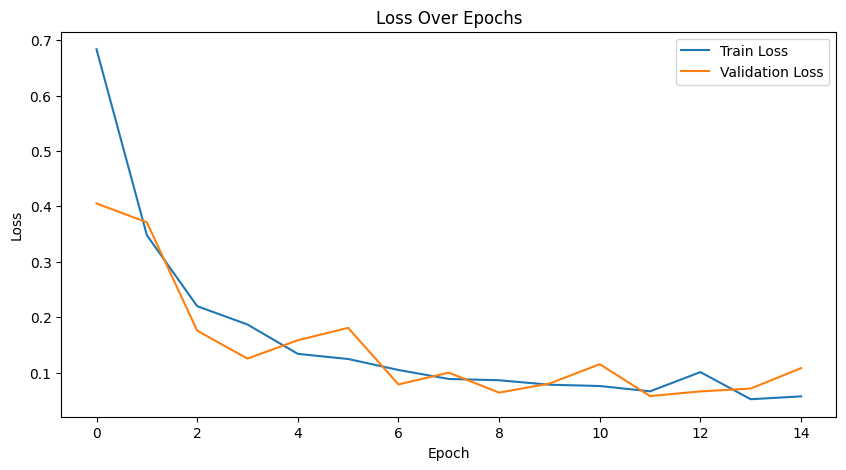

In [11]:
# Generate predictions on training data
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Plot accuracy and loss
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()


plt.show()

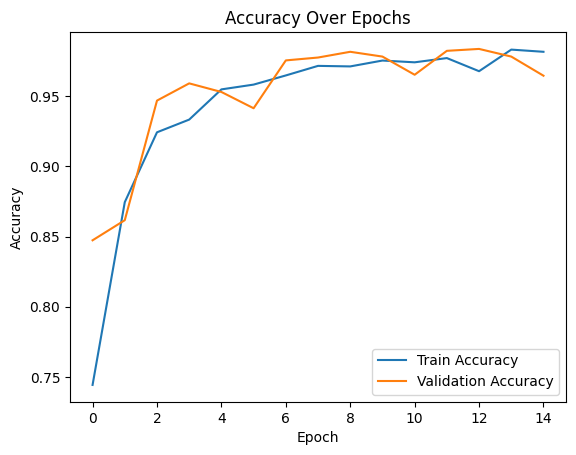

In [9]:
# plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [13]:
# Generate classification report on training data
class_report = classification_report(all_labels, all_preds)
print(class_report)
# Generate classification matrix
class_matrix = confusion_matrix(all_labels, all_preds)
print(class_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1699
           1       0.99      1.00      0.99      1610
           2       1.00      0.94      0.97      1668
           3       0.97      0.99      0.98      1700
           4       0.99      1.00      0.99      1734
           5       0.95      0.96      0.96      1858

    accuracy                           0.98     10269
   macro avg       0.98      0.98      0.98     10269
weighted avg       0.98      0.98      0.98     10269

[[1698    0    0    1    0    0]
 [   0 1606    0    0    0    4]
 [   0    6 1566   21    1   74]
 [   0    4    0 1687    0    9]
 [   0    0    0    1 1732    1]
 [   3   11    2   36   17 1789]]


In [14]:
# Generate predictions on validation data
all_valid_preds = []
all_valid_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in valid_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_valid_preds.extend(preds.cpu().numpy())
        all_valid_labels.extend(labels.cpu().numpy())


In [15]:
# Generate classification report on training data
class_report = classification_report(all_valid_labels, all_valid_preds)
print(class_report)
# Generate classification matrix
class_matrix = confusion_matrix(all_labels, all_preds)
print(class_matrix)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       263
           1       0.97      1.00      0.99       203
           2       1.00      0.88      0.93       258
           3       0.96      0.98      0.97       262
           4       0.98      1.00      0.99       235
           5       0.90      0.94      0.92       246

    accuracy                           0.96      1467
   macro avg       0.97      0.97      0.97      1467
weighted avg       0.97      0.96      0.96      1467

[[1698    0    0    1    0    0]
 [   0 1606    0    0    0    4]
 [   0    6 1566   21    1   74]
 [   0    4    0 1687    0    9]
 [   0    0    0    1 1732    1]
 [   3   11    2   36   17 1789]]


In [17]:
# Save the trained model
torch.save(model.state_dict(), "/content/drive/My Drive/AI Models/inceptionv3_model_1.pth")

In [19]:
# Generate predictions on test data
all_preds_test = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())
accuracy = metrics.accuracy_score(all_labels_test, all_preds_test)
print("Accuracy:", accuracy)

Accuracy: 0.9628620102214651


In [20]:
# Generate classification report of test dataset
class_report_test = classification_report(all_labels_test, all_preds_test)
print(class_report_test)
# Generate classification matrix of test dataset
class_matrix_test = confusion_matrix(all_labels, all_preds)
print(class_matrix_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       478
           1       0.98      1.00      0.99       446
           2       1.00      0.88      0.93       514
           3       0.91      0.98      0.94       478
           4       0.99      1.00      0.99       476
           5       0.92      0.94      0.93       543

    accuracy                           0.96      2935
   macro avg       0.97      0.96      0.96      2935
weighted avg       0.96      0.96      0.96      2935

[[1698    0    0    1    0    0]
 [   0 1606    0    0    0    4]
 [   0    6 1566   21    1   74]
 [   0    4    0 1687    0    9]
 [   0    0    0    1 1732    1]
 [   3   11    2   36   17 1789]]


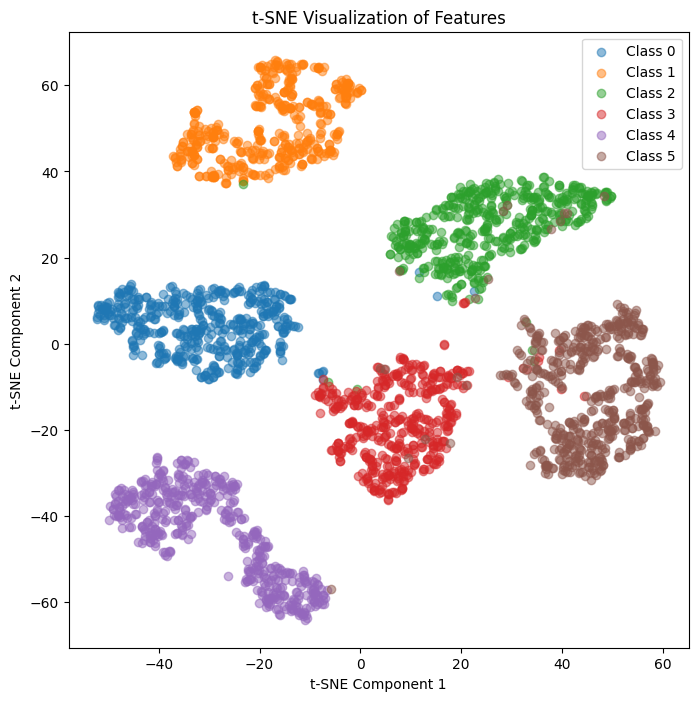

In [ ]:
# Get features from the penultimate layer of the Inception model
features = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

features = np.array(features)
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(num_classes):
    plt.scatter(embedded_features[np.array(all_labels_test) == class_idx, 0],
                embedded_features[np.array(all_labels_test) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

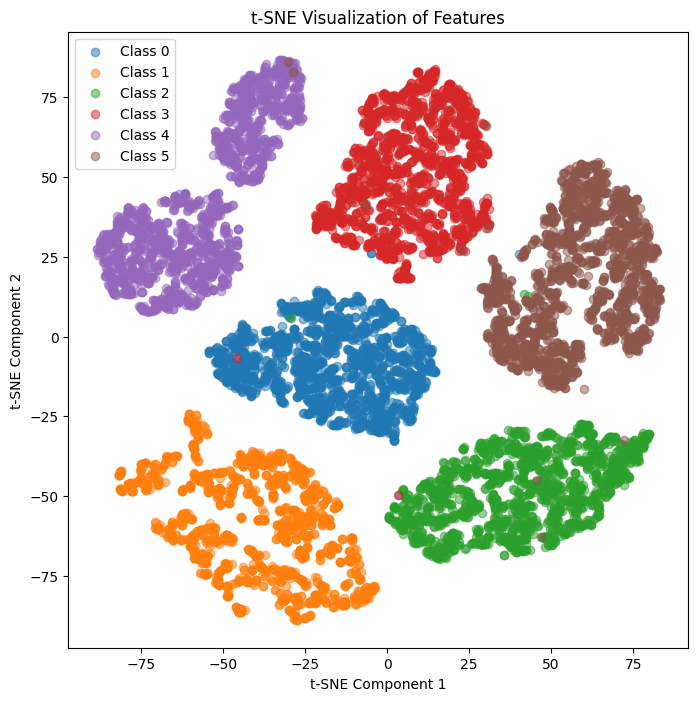

In [ ]:
# Get features from the penultimate layer of the Inception model
features = []
all_labels_train = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

features = np.array(features)
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(num_classes):
    plt.scatter(embedded_features[np.array(all_labels_train) == class_idx, 0],
                embedded_features[np.array(all_labels_train) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()